# Machine Learning Exercise - Feed Forward Neural Network

Hey there, hi there, ho there, dear reader! 
Today, Andrew Ng's machine learning class (https://www.coursera.org/learn/machine-learning) has tasked us with implementing a neural network that accurately classifies hand-written digits, basically pictures of 0-9 written by hand which were then labeled with the text representation of that number. This is the same data set used in the logistic regression exercise, but this time we will create a basic feed-forward neural network with backpropagation in python 3.0. It's important to remember that for neural networks we need to randomly initialize our weights (parameters (numbers we multiple by to guess what the correct answer is)), where as with models like linear and logistic regression, it's okay to use zero-intialization. Additionally, we will completely vectorize our code. What does that mean? It means using linear algebra instead of explicit for-loops when doing computations. Why? Because linear algebra libraries are optimized, so the code runs faster and the code is easier to read. After coding up a neural network from scratch, we'll implement the same neural network in Keras, a highly abstracted neural network python library.

Enough talk! Let's load up the data!

This notebook was inspired by http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-1/. Check out his webpage if you're interesting in machine learning or data science.

In [12]:
#this code assumes the data file is in the same directory as the code file
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

As you can see, X is a matrix with the grayscale values of pixels that equate to the picture in question. y is a vector where each element corresponds to a row from our X matrix.
Let's change X and y into something a bit more comfortable.

In [13]:
y = data['y']
# Add intercept or bias term
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]

print('X:',X.shape, '(+ bias term)')
print('y:',y.shape)

X: (5000, 401) (+ bias term)
y: (5000, 1)


So X is a 5000 by 401 matrix, meaning 5000 data examples or rows (the value 'm') and 401 columns; in machine learning columns are often called features. The 400 comes from the fact that pictures from our data are 20x20 pixels and the number in each cell is the grayscale value of the pixel in question. 1 comes from adding the bias or intercept term, which allows us to fit the data more accurately because we don't force our model to pass through the origin. y is a 5000 by 1 column vector will 5000 elements that correspond to whatever picture X's grayscale pixel values are supposed to represent.

... What? A picture is worth a thousand words so let's take a look!

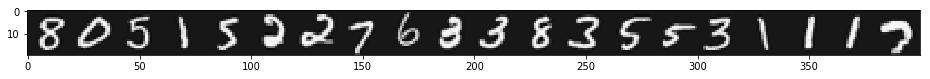

In [147]:
ran_samp = np.random.choice(X.shape[0], 20)
plt.figure(figsize = (16, 16))
plt.imshow(X[ran_samp, 1:].reshape(-1, 20).T, cmap = cm.Greys_r) 

So one row of X is the grayscale values corresponding to one of the numbers above. Meanwhile, one element of y is the text representation or the label for one of the above pictures.

Because of the nature of neural networks, we need to convert the elements of y from scalar or real numbers into vectors. This is called one-hot encoding. Basically we will create a vector with nine 0s and one 1 for each unique label we have in our data. Our data only take on the values 0-9, so that's 10 one-hot encoded vectors. In other words, one-hot encoding converts a class label n (out of k classes) into a vector of length k, where the index n is "hot" (1) while the rest are zero. We will then fill a "y matrix" with these vectors. Luckily for us, Scikit-learn, a machine learning library, is already set up to do this.

In [16]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
y_onehot, y_onehot.shape

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]), (5000, 10))

We could also use pandas for this! I prefer scikit-learn, though, so this notebook will use the above variables. But, for your reference:

In [17]:
import pandas as pd
y_matrix = pd.get_dummies(y.ravel()).as_matrix() 
y_matrix, y_matrix.shape

(array([[0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=uint8), (5000, 10))

Now that our data is all set up, it's time for the main event. The neural network Andrew Ng has asked us to build has an input layer corresponding to the features of our data (400 + the bias or intercept term), a hidden layer with 25 units (26 if you include the bias unit), and an output layer with 10 units for each of our class labels. If you're feeling frisky and want more info, please check out the PDF in this repo, which also contains a picture of our network architecture.

Let's first code up the sigmoid or logistic function, which converts real numbers into probabilities. This function, g(z), is defined as:

#### Sigmoid or logistic function
#### $$ g(z) = \frac{1}{1+e^{-z}}$$

In [18]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Not too bad, right? Now let's draw a plot and see if it will give us that beautiful 'S' line.

Text(0.5,1,'Sigmoid S')

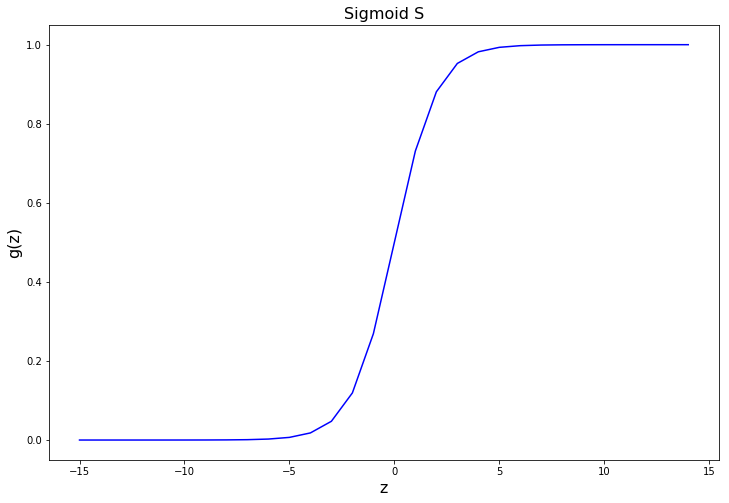

In [19]:
digits = np.arange(-15, 15, step=1)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(digits, sigmoid(digits), 'b')
plt.xlabel('z',fontsize=16)
plt.ylabel('g(z)',fontsize=16)
plt.title('Sigmoid S',fontsize=16)

Notice how the sigmoid function asymptotes at 0 and 1? That means it's smashed all our values into probabilities. This type of function is called the activation function and is repeated over and over again in neural networks. If you're familiar with logistic regression, neural networks are often called "stacked logistic regression."

Because the sigmoid function asymptotes at 0 and 1, the derivative at those values is close to 0, which slows learning down. In modern machine learning or deep learning, people typically use tanh, ReLu (rectified linear unit), or leaky ReLu as their activation function, because those don't suffer from the near-zero derivative problem. But who am I to argue with Andrew Ng? At any rate, I think you'll find ol' sigmoid does just fine for this task.

Now let's do random intialization. We need to set up a matrix to store and update our parameter values for each layer of our network, excluding the input layer. In this case, that's two layers: one hidden layer and one output layer. We will then fill the matrix with small random values. We use random-intialization to let each unit in our network learn its own unique and interesting function. If we did zero-intialization, each node would be learning the same function and be redundant.

First, we need to set up the parameters of our neural network. These are also given in the exercise PDF, but for your reference, dear reader:
#### Neural Network
Input layer size = 400 (20x20 pixels) <br>
Hidden layer size = 25 <br>
Number of labels = 10 <br>
Regularization parameter = 1

In [131]:
# initial setup
input_size = 400
hidden_size = 25
num_labels = 10
reg = 1

In [132]:
# initialize a random parameter array of the size of our network's parameters
# 1s are added for the bias term in the input layer and for the bias unit in the hidden layer
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25


# unravel the parameter array into parameter matrices for each layer
theta1 = params[0:(hidden_size * (input_size + 1))].reshape(hidden_size, (input_size + 1))
theta2 = params[(hidden_size * (input_size + 1)):].reshape(num_labels, (hidden_size + 1))

params.shape, theta1.shape, theta2.shape

((10285,), (25, 401), (10, 26))

Now we need to write some code for forward propagation.

#### Forward Propagation
$$ a^{(1)} = x $$
$$ z^{(2)} = \Theta^{(1)}a^{(1)} $$
$$ a^{(2)} = g(z^{(2)}) \quad (add \quad a_0^{(2)}) $$
$$ z^{(3)} = \Theta^{(2)}a^{(2)} $$
$$ a^{(3)} = h_\Theta(x) = g(z^{(3)}) $$

Forward propagation essentially computes our hypothesis or our network's guess based on our current parameter values. We denote our hypothesis by the letter 'h', which is dependent on computations from the previous layers. As we update our parameters (our theta matrixes) our hypthothesis will also change. We will return the values for each layer in order to do backpropagation later. Remember: for-loops should be avoided at all costs so we need to vectorize our approach.

In [133]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    
    a1 = X
    z2 = a1.dot(theta1.T)
    #ones for the bias unit
    a2 = np.insert(sigmoid(z2), 0, values = np.ones(m), axis = 1)
    z3 = a2.dot(theta2.T)
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

Now we need to create our cost function, which is a beast! The equations for both the cost function with and without regularization are given below. 

#### Cost Function 
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

#### Regularized Cost Function
#### $$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

The cost/loss/error function basically computes how bad our network's guess is. Our goal is to minimize our cost function, which we can do by manipulating our parameter values.

If you're intimidated by the above equations, you're not alone. The first term of the regularized cost function just computes our network's error summed up over all of our data. The second term is called regularization and it tries to keep the values of both theta matrices as small as possible. Why do we want them small? Because we're trying to avoid overfitting to our data. If we can avoid overfitting, then hopefully our model will perform well on data it has never seen before.

Now we just need to code it up!

In [134]:
def cost(params, input_size, hidden_size, num_labels, X, y, reg):
    m = X.shape[0]

    # reshape the our theta vectors into theta matrices for the hidden layer and the output layer   
    theta1 = params[0:(hidden_size * (input_size + 1))].reshape(hidden_size, (input_size + 1))
    theta2 = params[(hidden_size * (input_size + 1)):].reshape(num_labels, (hidden_size + 1))
     
    #We need h
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = -1 * (1 / m) * np.sum((np.log(h) * (y) + np.log(1 - h) *(1 - y))) +\
    (float(reg) / (2 * m)) * (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
    
    return J

Notice the lack of for-loops? Vectorization is a beautiful thing.


The worst part about all this is making sure your matrix dimensions make sense. Let's take a look and convince ourselves that we're doing something sensible.

In [135]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

... Looks reasonable I guess...


Now, let's take our cost function for a spin. This function computes how different our model's guess is from the true label. In other words, what's the difference between our hypothesis (h) and our label (y)?

In [136]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot, reg)

7.147201757616735

That's not good... typically you want to see a cost below 0.6.

What we need is an algorithm to reduce our cost. We're in luck because this algorithm is called backpropagation. Backpropagation computes the partial derivatives of our parameters for each layer, excluding the input layer. We can then use the derivatives as a guide to find a local (or if we're lucky a global) minimum of our cost function. If we find a minimum, we can use its values to update the values of our parameters and minimize our cost. Because we used the sigmoid activation function, the first thing we need is a function that computes the derivative (also called the gradient) of the sigmoid function.


#### Sigmoid gradient
#### $$ g'(z) = g(z)(1 - g(z))$$
where $$ g(z) = \frac{1}{1+e^{-z}}$$


In [137]:
def sigmoid_gradient(z):
    
    return(sigmoid(z) * (1 - sigmoid(z)))

Time for backpropagation, which may be the hardest thing in all of machine learning. Because backprop is dependent the values of everything we've talked about so far, we'll bring it all together below. We will use the variable $\delta$ is represent the partial derivatives of J of theta with respect to z ($\frac{\delta}{{\delta z^{(l)}}} J(\Theta^{(l)})$) which is just a vector. This capital delta ($\Delta$) is a matrix of all theses partial derivatives. Then by accumlating all these derivatives and following the equations below, we can put them together into D which becomes the partial derivative of J of theta with respect to a given theta. ($\frac{\delta}{{\delta \Theta^{(l)}}} J(\Theta^{(l)})$)  

Remember, daddio, for-loops are for squares!

#### Backpropagation
$$ \delta^{(3)} = a^{(3)} - y = h_\Theta(x) - y $$ 
$$ \delta^{(2)} = \Theta^{(2)T}\delta^{(3)}.*g'(z^{(2)}) $$
$$ \Delta^{(l)} := \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T $$
$$ D^{(l)} := \frac{1} {{m}} \Delta^{(l)}+ \lambda \Theta^{(l)} \quad if \quad j \neq 0 $$
$$ D^{(l)} := \frac{1} {{m}} \Delta^{(l)} \quad if \quad j = 0 $$

$$ D^{(l)} = \frac{\delta}{{\delta \Theta^{(l)}}} J(\Theta^{(l)}) $$

In [138]:
def backprop(params, input_size, hidden_size, num_labels, X, y, reg):
    m = X.shape[0]
    # reshape the our theta vectors into theta matrices for the hidden layer and the output layer
    theta1 = params[0:(hidden_size * (input_size + 1))].reshape(hidden_size, (input_size +1))
    theta2 = params[(hidden_size * (input_size + 1)):].reshape(num_labels, (hidden_size + 1))
   
    
    # propagate the network with a guess
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # compute the cost of that guess
    J = cost(params, input_size, hidden_size, num_labels, X, y, reg)
     
    
   # perform backprop so we can try to make a better guess next time
    d3 = h - y

    d2 = theta2[:,1:].T.dot(d3.T) * sigmoid_gradient(z2).T # 25x10 *10x5000 * 25x5000 = 25x5000
    
  
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape) # (10, 26)
    
    delta1 = delta1 + d2.dot(a1) # 25x5000 * 5000x401 = 25x401
    delta2 = delta2 + d3.T.dot(a2) # 10x5000 *5000x26 = 10x26
    
    delta1 = delta1 / m
    delta2 = delta2 / m
    
  
    #combine our two theta matrices into a row vector
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    
    return J, grad

Once you understand the purpose of backprop-no small feat-, the only hard part is getting your matrix dimensions right, which is the hardest part of any machine learning task. I recommend liberal use of ".shape". 


Let's take a look and hope it outputs something meaningful and doesn't crash.

In [139]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot, reg)
J, grad.shape

(7.147201757616735, (10285,))

Okay, now we can use the output of backprop to minimize our cost function. One way to do that is gradient descent, which is an iterative algorithm that just repeats backprop until convergence or our cost is small enough that we don't care to minimize it anymore. Instead, let's use scipy's more intelligent minimization functions that do that same thing as gradient descent only faster. For more info, please see https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html.

We just need to pass it backprop, our initial guess (random initializations of our parameters), and the same variables we gave backprop. Then scipy will do the rest!

In [140]:
from scipy.optimize import minimize

# minimize our cost function
res = minimize(fun=backprop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, reg), 
                method='TNC', jac=True, options={'maxiter': 250})
res

     fun: 0.5951301856444693
     jac: array([-1.54163741e-04,  0.00000000e+00,  0.00000000e+00, ...,
       -1.67799012e-03, -1.24871755e-03,  1.79462599e-05])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 147
     nit: 13
  status: 1
 success: True
       x: array([ 0.32392168, -0.10670771,  0.04667098, ...,  0.49888424,
       -1.09725559, -2.55229412])

We converged~ yay~ 

As you can see, this function outputs a solution array containing the optimized values of our parameters. Our total cost is below 0.6, so at that's an encouraging sign that we've done something right. Now we can use our optimized parameter values from the solution arrary, forward propagate them through our network, and make some predictions.

In [141]:
# reshape the our theta vectors into theta matrices for the hidden layer and the output layer 
# this time using the solution array
theta1 = res.x[0:(hidden_size * (input_size + 1))].reshape(hidden_size, (input_size + 1))
theta2 = res.x[(hidden_size * (input_size + 1)):].reshape(num_labels, (hidden_size + 1))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

#because of python indexing add one to get true value predictions
predictions = np.array(np.argmax(h, axis=1) + 1)

At long last we can finally see if our neural network makes decent predictions. The way to do this is by comparing our network's output with the true label. Then, we can divide our total number of successes by the number of guesses we made, in our case, 5,000. This metric is called accuracy.

To my great shame, dear reader, there is a for-loop below. I hope you will find it in your heart to forgive me.

In [142]:
correct = [1 if a == b else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) / len(correct))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.38%


Too legit! Due to random intialization, the accuracy might jump around by 2% or so, but this is a nice result, very similar to what Andrew Ng's exercise indicated we should expect.

Should we take a deeper look at the artificial brain we just cooked up? Of course we should! Remember our theta1? The parameter matrix of our network's hidden layer? Well, it turns out we can use those parameter values to visualize the picture features our network was learning at that point in training. Let's pry open this neural blackbox and take a look under the hood!

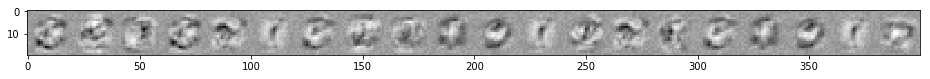

In [157]:
ran_samp = np.random.choice(theta1.shape[0], 20)
plt.figure(figsize = (16, 16))
plt.imshow(theta1[ran_samp, 1:].reshape(-1, 20).T, cmap = cm.Greys_r)

Woah! You can almost see numbers starting to form, like the network is beginning to understand what a handwritten number might look like.

We just coded up a completely vectorized, feed-forward neural network with backpropagation without using any neural network libraries like Tensorflow, Pytorch or Theano. We then used our network to classify images of handwritten digits, which is an important task in computer vision. 

Now, let's check out Keras, a neural network library in Python, and build our neural network there as well.

We've actually been cheating by training our network and testing our network on the same data set. In order to get an idea of how accurately our model will perform in a real world scenario, we need to divide our data into a training set and a test or validation set. In small data settings, like this one, this is typically done by allocating 80% of the data to the training set and 20% to the test set. However, we're now faced with a problem: our data is logically ordered! This is bad because it will limit our model's exposure certain data types. We can overcome this combining the data into a pandas dataframe and randomly shuffling it with scikit learn.

In [158]:
import pandas as pd
data2 = pd.DataFrame(data['X'])

#add y to the new dataframe
data2['y'] = data['y']

from sklearn.utils import shuffle
data2 = shuffle(data2)

In [159]:
#reconvert to appropriate dimensions
y = np.matrix(data2['y']).T
X = data2.iloc[:,0:400]

Now we can once again use scikit learn to create our one-hot encoded vectors and additionally we can use it to split our data up into 80% for training and 20% for testing.

In [163]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 400), (1000, 400), (4000, 10), (1000, 10))

Now let's build our network! We'll use Sequential to indicate that the layers of our model are linearly ordered. We then use Dense to indicate that each unit or neuron is connected to each unit or neuron in the next layer.

We will add one hidden layer with 25 units or neurons where we will use a softmax activation function, which is simply the logistic or sigmoid function. The input shape the hidden layer matches the number of features in our model, in this case 400 (20x20 pixel images). Our output layer will also use the softmax activation function, but with only 10 neurons corresponding to the 10 (0-9) possible values we're trying to predict.

To be consistent with Andrew Ng, let's use the softmax function, but there are other activation functions availble, even more useful than our beloved sigmoid function. Check them out and play with them: https://keras.io/activations/

Note that, in this case, the final layer should use softmax activation in order to yield a probability.

In [165]:
from keras.models import Sequential
from keras.layers import Dense
 
model = Sequential()
model.add(Dense(25, activation='softmax', input_shape=(400,)))
model.add(Dense(10, activation='softmax'))

Now we'll configure the model. My choices for the optimizer and cost function are mostly arbitrary, similar to the optimization function chosen above. Feel free to play around with them and check out how the results change!
For more info see:


https://keras.io/losses/   
https://keras.io/optimizers/.

In [166]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Batch size is the number of training samples we forward propogate into the network at a time. Epochs just mean the number of times the network sees the data (iterations).

In general, larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. Models typically improve with more epochs of training, to a point. They'll start to plateau in accuracy as they converge.

We'll save our model as history so we can use the values later for drawing plots

In [167]:
history = model.fit(X_train, y_train, batch_size=128, epochs=250, verbose=1, validation_data=(X_test, y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/250
4000/4000 [==============================] - 0s 99us/step - loss: 2.2624 - acc: 0.2915 - val_loss: 2.2285 - val_acc: 0.4320
Epoch 2/250
4000/4000 [==============================] - 0s 16us/step - loss: 2.1908 - acc: 0.5700 - val_loss: 2.1597 - val_acc: 0.5920
Epoch 3/250
4000/4000 [==============================] - 0s 16us/step - loss: 2.1176 - acc: 0.6292 - val_loss: 2.0896 - val_acc: 0.6020
Epoch 4/250
4000/4000 [==============================] - 0s 16us/step - loss: 2.0505 - acc: 0.6370 - val_loss: 2.0300 - val_acc: 0.6020
Epoch 5/250
4000/4000 [==============================] - 0s 16us/step - loss: 1.9931 - acc: 0.6245 - val_loss: 1.9770 - val_acc: 0.5870
Epoch 6/250
4000/4000 [==============================] - 0s 16us/step - loss: 1.9415 - acc: 0.6225 - val_loss: 1.9284 - val_acc: 0.6070
Epoch 7/250
4000/4000 [==============================] - 0s 16us/step - loss: 1.8922 - acc: 0.6510 - val_loss: 1.8792 - val_acc: 0.6470


4000/4000 [==============================] - 0s 18us/step - loss: 0.4019 - acc: 0.9485 - val_loss: 0.4725 - val_acc: 0.9150
Epoch 61/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.3898 - acc: 0.9485 - val_loss: 0.4618 - val_acc: 0.9160
Epoch 62/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.3782 - acc: 0.9500 - val_loss: 0.4520 - val_acc: 0.9160
Epoch 63/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.3673 - acc: 0.9513 - val_loss: 0.4430 - val_acc: 0.9200
Epoch 64/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.3566 - acc: 0.9517 - val_loss: 0.4336 - val_acc: 0.9180
Epoch 65/250
4000/4000 [==============================] - 0s 19us/step - loss: 0.3466 - acc: 0.9525 - val_loss: 0.4238 - val_acc: 0.9170
Epoch 66/250
4000/4000 [==============================] - 0s 18us/step - loss: 0.3366 - acc: 0.9532 - val_loss: 0.4154 - val_acc: 0.9160
Epoch 67/250
4000/4000 [==============================

Epoch 120/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.1343 - acc: 0.9725 - val_loss: 0.2906 - val_acc: 0.9230
Epoch 121/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.1329 - acc: 0.9725 - val_loss: 0.2911 - val_acc: 0.9220
Epoch 122/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.1320 - acc: 0.9728 - val_loss: 0.2897 - val_acc: 0.9240
Epoch 123/250
4000/4000 [==============================] - 0s 19us/step - loss: 0.1307 - acc: 0.9730 - val_loss: 0.2896 - val_acc: 0.9230
Epoch 124/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.1292 - acc: 0.9725 - val_loss: 0.2929 - val_acc: 0.9230
Epoch 125/250
4000/4000 [==============================] - 0s 20us/step - loss: 0.1285 - acc: 0.9738 - val_loss: 0.2914 - val_acc: 0.9220
Epoch 126/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.1274 - acc: 0.9735 - val_loss: 0.2896 - val_acc: 0.9210
Epoch 127/250
4000/4000 [=========

4000/4000 [==============================] - 0s 16us/step - loss: 0.0876 - acc: 0.9830 - val_loss: 0.3146 - val_acc: 0.9210
Epoch 180/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.0871 - acc: 0.9828 - val_loss: 0.3158 - val_acc: 0.9220
Epoch 181/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.0865 - acc: 0.9828 - val_loss: 0.3153 - val_acc: 0.9210
Epoch 182/250
4000/4000 [==============================] - 0s 19us/step - loss: 0.0860 - acc: 0.9830 - val_loss: 0.3175 - val_acc: 0.9220
Epoch 183/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.0852 - acc: 0.9832 - val_loss: 0.3179 - val_acc: 0.9200
Epoch 184/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.0850 - acc: 0.9832 - val_loss: 0.3184 - val_acc: 0.9210
Epoch 185/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.0842 - acc: 0.9832 - val_loss: 0.3194 - val_acc: 0.9230
Epoch 186/250
4000/4000 [=======================

4000/4000 [==============================] - 0s 16us/step - loss: 0.0616 - acc: 0.9878 - val_loss: 0.3608 - val_acc: 0.9150
Epoch 239/250
4000/4000 [==============================] - 0s 18us/step - loss: 0.0615 - acc: 0.9880 - val_loss: 0.3601 - val_acc: 0.9180
Epoch 240/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.0613 - acc: 0.9880 - val_loss: 0.3625 - val_acc: 0.9150
Epoch 241/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.0610 - acc: 0.9875 - val_loss: 0.3630 - val_acc: 0.9140
Epoch 242/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.0606 - acc: 0.9882 - val_loss: 0.3631 - val_acc: 0.9150
Epoch 243/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.0605 - acc: 0.9878 - val_loss: 0.3624 - val_acc: 0.9160
Epoch 244/250
4000/4000 [==============================] - 0s 16us/step - loss: 0.0602 - acc: 0.9880 - val_loss: 0.3644 - val_acc: 0.9120
Epoch 245/250
4000/4000 [=======================

Now let's see how we did!

In [168]:
[test_cost, test_acc] = model.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

1000/1000 [==============================] - 0s 15us/step
Evaluation result on Test Data : Cost = 0.3679812917709351, accuracy = 91.5


Not too shabby! Not as good as our hand-crafted model, but remember, we cheated then! Let's draw some plots to visualize our cost and accuracy as the model became more familiar with the data. 

Text(0.5,1,'Accuracy Curves')

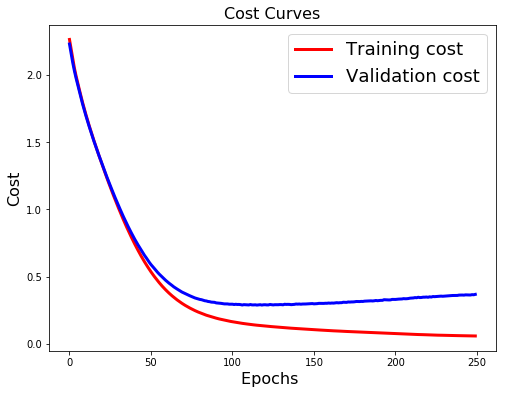

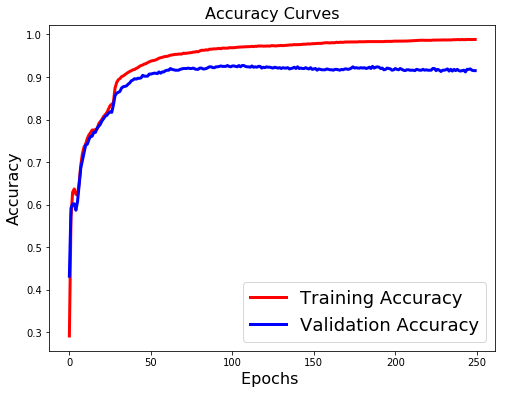

In [169]:
#Plot cost
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training cost', 'Validation cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Cost Curves',fontsize=16)
 
#Plot accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

As you can see, our training cost and accuracy only get better the more the model sees the data, while for the validation set, we've plateaued! This is a clear indicator that our model is overfit. In fact if you crank up the Epochs to 1000 or 10000, you'd see the test cost and accuracy get worse and worse while the training cost and accuracy get better and better. So, more Epochs in not necessarily a good thing! One fix for this overfitting problem is called dropout. You can think of dropout as additional neural network regularization, on top of the regularization we already implemented.

In a nut shell, dropout randomly turns off a percentage of the units or neurons in a given layer which discourages overfitting. Since the hidden size of the neural network in this assignment is very small, we'll only shut off 15% of the neurons. In neural networks with larger hidden sizes, the dropout number is usually much higher, like 50%.

In [176]:
from keras.layers import Dropout
 
model_dropout = Sequential()
model_dropout.add(Dense(25, activation='softmax', input_shape=(400,)))
model_dropout.add(Dropout(0.15))
model_dropout.add(Dense(10, activation='softmax'))

Now we can just configure a new model in the same way as before!

In [177]:
model_dropout.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history_dropout = model_dropout.fit(X_train, y_train, batch_size=128, epochs=250, verbose=1, validation_data=(X_test, y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/250
4000/4000 [==============================] - 0s 64us/step - loss: 2.2650 - acc: 0.2650 - val_loss: 2.2320 - val_acc: 0.4680
Epoch 2/250
4000/4000 [==============================] - 0s 18us/step - loss: 2.1951 - acc: 0.5007 - val_loss: 2.1643 - val_acc: 0.5810
Epoch 3/250
4000/4000 [==============================] - 0s 18us/step - loss: 2.1233 - acc: 0.5703 - val_loss: 2.0962 - val_acc: 0.6100
Epoch 4/250
4000/4000 [==============================] - 0s 18us/step - loss: 2.0558 - acc: 0.5773 - val_loss: 2.0364 - val_acc: 0.5950
Epoch 5/250
4000/4000 [==============================] - 0s 17us/step - loss: 1.9989 - acc: 0.5707 - val_loss: 1.9820 - val_acc: 0.5980
Epoch 6/250
4000/4000 [==============================] - 0s 18us/step - loss: 1.9430 - acc: 0.5740 - val_loss: 1.9314 - val_acc: 0.6070
Epoch 7/250
4000/4000 [==============================] - 0s 17us/step - loss: 1.8987 - acc: 0.5752 - val_loss: 1.8852 - val_acc: 0.6190


4000/4000 [==============================] - 0s 18us/step - loss: 0.6237 - acc: 0.8265 - val_loss: 0.5077 - val_acc: 0.9090
Epoch 61/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.6127 - acc: 0.8255 - val_loss: 0.4965 - val_acc: 0.9100
Epoch 62/250
4000/4000 [==============================] - 0s 18us/step - loss: 0.6034 - acc: 0.8290 - val_loss: 0.4867 - val_acc: 0.9090
Epoch 63/250
4000/4000 [==============================] - 0s 20us/step - loss: 0.6194 - acc: 0.8162 - val_loss: 0.4775 - val_acc: 0.9100
Epoch 64/250
4000/4000 [==============================] - 0s 20us/step - loss: 0.5925 - acc: 0.8295 - val_loss: 0.4684 - val_acc: 0.9120
Epoch 65/250
4000/4000 [==============================] - 0s 20us/step - loss: 0.6058 - acc: 0.8255 - val_loss: 0.4616 - val_acc: 0.9140
Epoch 66/250
4000/4000 [==============================] - 0s 18us/step - loss: 0.5883 - acc: 0.8273 - val_loss: 0.4516 - val_acc: 0.9140
Epoch 67/250
4000/4000 [==============================

Epoch 120/250
4000/4000 [==============================] - 0s 18us/step - loss: 0.4491 - acc: 0.8482 - val_loss: 0.3027 - val_acc: 0.9240
Epoch 121/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4499 - acc: 0.8455 - val_loss: 0.3033 - val_acc: 0.9250
Epoch 122/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4678 - acc: 0.8390 - val_loss: 0.3034 - val_acc: 0.9270
Epoch 123/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4593 - acc: 0.8420 - val_loss: 0.3028 - val_acc: 0.9260
Epoch 124/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4452 - acc: 0.8473 - val_loss: 0.3011 - val_acc: 0.9230
Epoch 125/250
4000/4000 [==============================] - 0s 18us/step - loss: 0.4495 - acc: 0.8475 - val_loss: 0.3023 - val_acc: 0.9260
Epoch 126/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4709 - acc: 0.8350 - val_loss: 0.3021 - val_acc: 0.9240
Epoch 127/250
4000/4000 [=========

4000/4000 [==============================] - 0s 17us/step - loss: 0.4056 - acc: 0.8572 - val_loss: 0.3084 - val_acc: 0.9230
Epoch 180/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4208 - acc: 0.8508 - val_loss: 0.3052 - val_acc: 0.9260
Epoch 181/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4170 - acc: 0.8510 - val_loss: 0.3083 - val_acc: 0.9220
Epoch 182/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4162 - acc: 0.8525 - val_loss: 0.3086 - val_acc: 0.9230
Epoch 183/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4032 - acc: 0.8558 - val_loss: 0.3067 - val_acc: 0.9240
Epoch 184/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4289 - acc: 0.8462 - val_loss: 0.3092 - val_acc: 0.9250
Epoch 185/250
4000/4000 [==============================] - 0s 18us/step - loss: 0.4081 - acc: 0.8552 - val_loss: 0.3088 - val_acc: 0.9230
Epoch 186/250
4000/4000 [=======================

4000/4000 [==============================] - 0s 18us/step - loss: 0.4218 - acc: 0.8508 - val_loss: 0.3195 - val_acc: 0.9220
Epoch 239/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.3960 - acc: 0.8580 - val_loss: 0.3189 - val_acc: 0.9240
Epoch 240/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.4132 - acc: 0.8512 - val_loss: 0.3206 - val_acc: 0.9230
Epoch 241/250
4000/4000 [==============================] - 0s 20us/step - loss: 0.4000 - acc: 0.8558 - val_loss: 0.3227 - val_acc: 0.9220
Epoch 242/250
4000/4000 [==============================] - 0s 19us/step - loss: 0.3894 - acc: 0.8602 - val_loss: 0.3224 - val_acc: 0.9250
Epoch 243/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.3644 - acc: 0.8728 - val_loss: 0.3205 - val_acc: 0.9240
Epoch 244/250
4000/4000 [==============================] - 0s 17us/step - loss: 0.3973 - acc: 0.8572 - val_loss: 0.3207 - val_acc: 0.9240
Epoch 245/250
4000/4000 [=======================

In [178]:
#Model with dropout evaluation
[test_cost, test_acc] = model_dropout.evaluate(X_test, y_test)
print("Evaluation result on Test Data : Cost = {}, accuracy = {}".format(test_cost, (test_acc*100)))

1000/1000 [==============================] - 0s 18us/step
Evaluation result on Test Data : Cost = 0.32309364292025566, accuracy = 92.0


Not bad! Behold the power of dropout!


Let's take a look at the dropout model's cost and accuracy.

Text(0.5,1,'Model with Dropout Accuracy Curves')

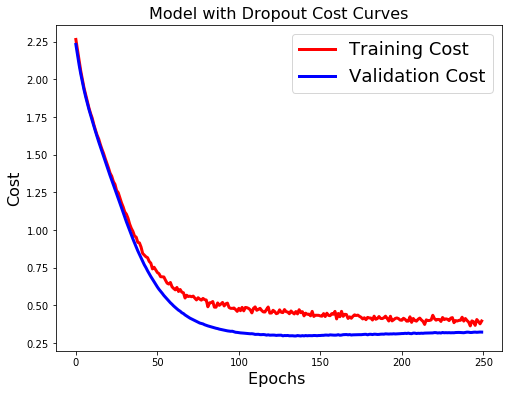

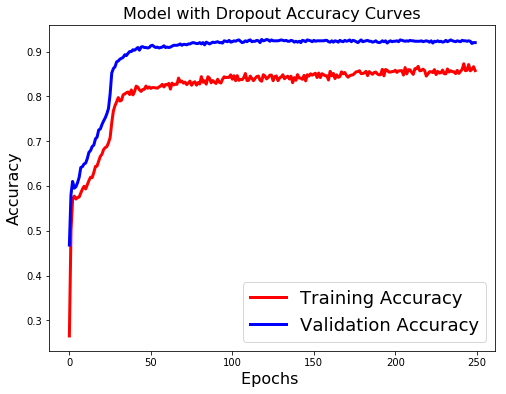

In [179]:
#Plot cost of model with dropout
plt.figure(figsize=[8,6])
plt.plot(history_dropout.history['loss'],'r',linewidth=3.0)
plt.plot(history_dropout.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training Cost', 'Validation Cost'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Cost',fontsize=16)
plt.title('Model with Dropout Cost Curves',fontsize=16)
 
#Plot accuracy of model with dropout
plt.figure(figsize=[8,6])
plt.plot(history_dropout.history['acc'],'r',linewidth=3.0)
plt.plot(history_dropout.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Model with Dropout Accuracy Curves',fontsize=16)

That looks much better! We're actually more accurate on the test set than we are on the training set, but I'm sure that wouldn't be the case for long if we increased the number of Epochs. At any rate, our model is more general now.

Thanks for reading, dear reader!